In [21]:
import yfinance as yf
import pandas as pd
import numpy as np

import torch
import torch.nn as nn

In [22]:

# Define the ticker symbol for Bitcoin
ticker = 'BTC-USD'

# Fetch historical data for Bitcoin
btc_data = yf.download(ticker, start='2010-01-01', end='2025-01-01')

# Save the data to a CSV file
btc_data.to_csv('bitcoin_historical_data.csv')

# Display the first few rows of the data


/tmp/ipython-input-2779621854.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc_data = yf.download(ticker, start='2010-01-01', end='2025-01-01')
[*********************100%***********************]  1 of 1 completed


In [23]:
def create_time_features(df, time_col='Date', freq='d'):
    """
    Creates time series features from a datetime index.
    """
    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col])
    df['month'] = df[time_col].dt.month
    df['day'] = df[time_col].dt.day
    df['weekday'] = df[time_col].dt.dayofweek
    # Add more features if needed, like 'weekofyear'

    # The TimeFeatureEmbedding expects these features in a specific order based on `freq`
    if freq == 'd': # Daily
        feature_cols = ['month', 'day', 'weekday']
    else: # Add more logic for other frequencies if needed
        raise NotImplementedError(f"Frequency '{freq}' not implemented.")

    return df[feature_cols].values

# This function creates input/output sequences
def create_sequences(input_data, time_features, seq_len, pred_len):
    X, y, X_mark = [], [], []
    for i in range(len(input_data) - seq_len - pred_len + 1):
        X.append(input_data[i:(i + seq_len)])
        y.append(input_data[i + seq_len:i + seq_len + pred_len])
        X_mark.append(time_features[i:(i + seq_len)])
    return np.array(X), np.array(y), np.array(X_mark)

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load Data
ticker = 'BTC-USD'
btc_data = yf.download(ticker, start='2014-01-01', end='2024-01-01')
btc_data.reset_index(inplace=True) # Move 'Date' from index to a column

# Feature Engineering
# 'Close' price - forecasting
price_data = btc_data[['Close']].values
# Create time features
time_features = create_time_features(btc_data, time_col='Date', freq='d')

# Scaling
scaler = StandardScaler()
# Fit only on the training data to avoid data leakage
train_size = int(len(price_data) * 0.8)
scaler.fit(price_data[:train_size])
scaled_data = scaler.transform(price_data)

# Create Sequences
class Configs:
    seq_len = 30 # Use 30 days of history
    pred_len = 1 # Predict 1 day ahead
    enc_in = 1 # We are using 1 feature (Close price)
    c_out = 1

configs = Configs()

X, y, X_mark = create_sequences(scaled_data, time_features, configs.seq_len, configs.pred_len)

# Split Data
X_train, X_test, y_train, y_test, X_mark_train, X_mark_test = train_test_split(
    X, y, X_mark, test_size=0.2, shuffle=False # Time series data should not be shuffled
)

# Convert to Tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_mark_train = torch.tensor(X_mark_train, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
X_mark_test = torch.tensor(X_mark_test, dtype=torch.float32)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_mark_train shape:", X_mark_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("X_mark_test shape:", X_mark_test.shape)

/tmp/ipython-input-3970751190.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc_data = yf.download(ticker, start='2014-01-01', end='2024-01-01')
[*********************100%***********************]  1 of 1 completed

X_train shape: torch.Size([2690, 30, 1])
y_train shape: torch.Size([2690, 1, 1])
X_mark_train shape: torch.Size([2690, 30, 3])
X_test shape: torch.Size([673, 30, 1])
y_test shape: torch.Size([673, 1, 1])
X_mark_test shape: torch.Size([673, 30, 3])


In [25]:
btc_data

Price,Date,Close,High,Low,Open,Volume
Ticker,,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
0,2014-09-17,457.334015,468.174011,452.421997,465.864014,21056800
1,2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200
2,2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700
3,2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600
4,2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100
...,...,...,...,...,...,...
3388,2023-12-27,43442.855469,43683.160156,42167.582031,42518.468750,25260941032
3389,2023-12-28,42627.855469,43804.781250,42318.550781,43468.199219,22992093014
3390,2023-12-29,42099.402344,43124.324219,41424.062500,42614.644531,26000021055


In [26]:
btc = btc_data["Close"]
btc

Ticker,BTC-USD
0,457.334015
1,424.440002
2,394.795990
3,408.903992
4,398.821014
...,...
3388,43442.855469
3389,42627.855469
3390,42099.402344
3391,42156.902344


In [27]:
btc = btc.values.flatten()

price = np.array([btc[i:i+17] for i in range(len(btc) - 16)])
price.shape

(3377, 17)

In [28]:
X, X_pred = price[:-500, :-1], price[-500:, :-1]
y, y_pred = price[:-500, -1:], price[-500:, -1:]
X.shape, y.shape

((2877, 16), (2877, 1))

In [29]:
class NbeatsBlock (nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers) -> None:
        '''
            input_size: int, size of the input
            hidden_size: int, size of the hidden layers
            output_size: int, size of the output
            n_layers: int, number of layers
        '''
        super().__init__()

        self.fc = nn.Sequential(
            *[nn.Sequential(
                nn.Linear(input_size if i == 0 else hidden_size, hidden_size if i < n_layers else output_size),
                nn.ReLU()
            ) for i in range(n_layers + 1)]
        )

    def forward(self, x):
        return self.fc(x)

In [30]:
class Nbeats(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=4, n_stacks=3) -> None:
        '''
            input_size: int, size of the input
            hidden_size: int, size of the hidden layers
            output_size: int, size of the output
            n_layers: int, number of layers
            n_stacks: int, number of stacks
        '''
        super().__init__()

        self.stacks = nn.ModuleList(
            [NbeatsBlock(input_size, hidden_size, output_size, n_layers) for _ in range(n_stacks)]
        )

    def forward(self, x):
        forcast = sum(stack(x) for stack in self.stacks)
        return forcast

In [31]:
# Hyperparameters
input_size = 16   # Number of past time steps
hidden_size = 128 # Hidden layer size
output_size = 1   # Number of future steps to predict
num_blocks = 3
num_layers = 4
lr = 0.001
epochs = 1000

# Create Model
model = Nbeats(input_size, hidden_size, output_size, num_blocks, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [32]:
X_train = torch.tensor(X, dtype=torch.float32)
y_train = torch.tensor(y, dtype=torch.float32)

In [33]:
# Training Loop
best_loss = float('inf') # Initialize best_loss to infinity

for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = model(X_train)
    loss = criterion(predictions, y_train)
    loss.backward()
    optimizer.step()

    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save(model.state_dict(), 'nbeats_bitcoin_prediction_best.pth')
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}, Model Saved')

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

Epoch 0, Loss: 389753536.0000, Model Saved
Epoch 0, Loss: 389753536.0000
Epoch 1, Loss: 270246656.0000, Model Saved
Epoch 2, Loss: 174865120.0000, Model Saved
Epoch 3, Loss: 99943360.0000, Model Saved
Epoch 4, Loss: 43671200.0000, Model Saved
Epoch 5, Loss: 10455505.0000, Model Saved
Epoch 6, Loss: 6360542.5000, Model Saved
Epoch 10, Loss: 44479828.0000
Epoch 14, Loss: 4010188.0000, Model Saved
Epoch 20, Loss: 15316106.0000
Epoch 25, Loss: 3836172.0000, Model Saved
Epoch 30, Loss: 7701958.0000
Epoch 34, Loss: 3832047.5000, Model Saved
Epoch 35, Loss: 3528261.2500, Model Saved
Epoch 40, Loss: 4730169.0000
Epoch 44, Loss: 3215006.5000, Model Saved
Epoch 45, Loss: 3096952.2500, Model Saved
Epoch 50, Loss: 3388665.5000
Epoch 52, Loss: 2930427.0000, Model Saved
Epoch 53, Loss: 2786651.2500, Model Saved
Epoch 54, Loss: 2747398.5000, Model Saved
Epoch 58, Loss: 2747250.0000, Model Saved
Epoch 59, Loss: 2639737.5000, Model Saved
Epoch 60, Loss: 2533980.2500, Model Saved
Epoch 60, Loss: 2533980

In [34]:
import matplotlib.pyplot as plt

# Make predictions on the training set
with torch.no_grad():
    predicted_train = model(X_train).numpy()

# Make predictions on the future set
X_pred_tensor = torch.tensor(X_pred, dtype=torch.float32)
with torch.no_grad():
    predicted_pred = model(X_pred_tensor).numpy()

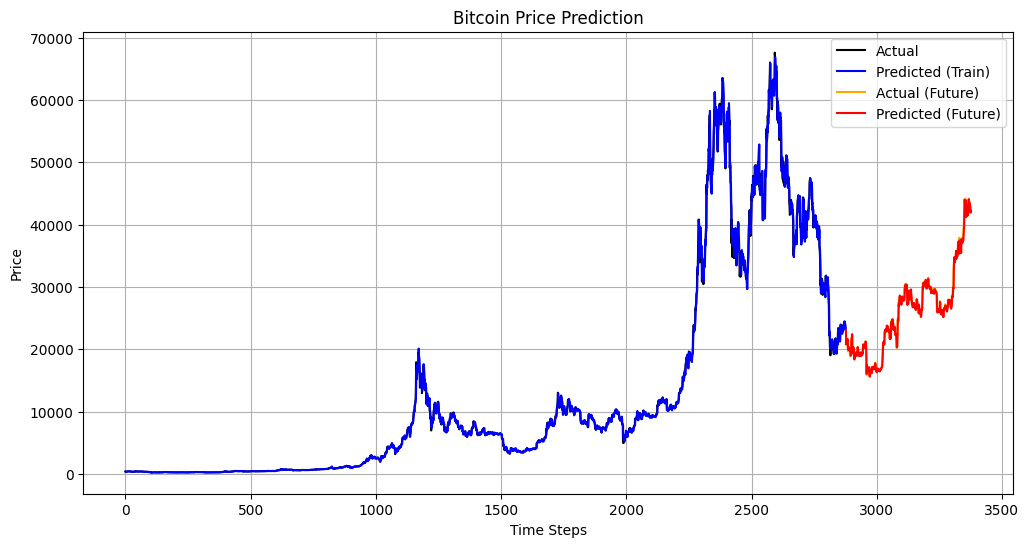

In [35]:
# prompt: plot a graph with y_train, and predicted value (in blue) and continuing the time series, (in red) with y_pred and predicted value from model

# Plotting the graph
plt.figure(figsize=(12, 6))

# Plot the actual values (y_train)
plt.plot(y, label='Actual', color='black')

# Plot the predicted values for the training data
plt.plot(predicted_train, label='Predicted (Train)', color='blue')

# Plot the continued time series with y_pred and predicted values
plt.plot(np.arange(len(y), len(y) + len(y_pred)), y_pred, label='Actual (Future)', color='orange')
plt.plot(np.arange(len(y), len(y) + len(y_pred)), predicted_pred, label='Predicted (Future)', color='red')

plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.title('Bitcoin Price Prediction')
plt.legend()
plt.grid(True)
plt.show()


In [36]:
# Save the model weights
torch.save(model.state_dict(), 'nbeats_bitcoin_prediction.pth')